# Pollinator Habitat Modelling across Landscapes

---

A stable workforce is vital for organisation's success, leading to increased productivity, cost effectiveness and retention of institutional knowledge. This project aims to predict the risk level of employee attrition, explore factors that affect attrition and propose intervention strategies. Cox Proportional Hazard regression model (CoxPH) and Random Survival Forest (RSF) will be used to assess events of turnover.

### Data Source

Our dataset is sourced from [IBM HR analytics synthetic data](https://github.com/IBM/employee-attrition-aif360/), made available under [Open Database License](https://opendatacommons.org/licenses/odbl/1.0/) and [Database Content License](https://opendatacommons.org/licenses/dbcl/1.0/).

### Analysis Tool

We will be using R for our data analysis.


## Importing Data

We set aside some verificational data to measure our performance.

In [1]:
# Importing data
rm(list = ls())
DATA <- read.csv("hr_data.csv")

# Save some for verification
set.seed(100)
SIZE <- round(0.1*nrow(DATA))
RAND <- sample(1:nrow(DATA))
VERI <- DATA[RAND[1:round(0.1*nrow(DATA))], ]
row.names(VERI) <- 1:nrow(VERI)
hr <- DATA[-RAND[1:round(0.1*nrow(DATA))], ]
row.names(hr) <- 1:nrow(hr)
#set.seed(NULL)

---

## Performing Data Wrangling

Firstly, we will look at the preview of the data and check for duplicates, missing values, data types and ranges.

In [2]:
# First few rows
head(hr, 10)
# Number of duplicated rows
nrow(hr[duplicated(hr), ])
# Number of empty values
sum(is.na(hr))
# All column's ranges and types
summary(hr)
sapply(hr, function(x) {
  unique_vals <- sort(unique(x))
  if (length(unique_vals) <= 30) return(unique_vals)
  return(c(unique_vals[1:30], "etc"))
})

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6
7,59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,⋯,1,80,3,12,3,2,1,0,0,0
8,30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,1,11,⋯,2,80,1,1,2,3,1,0,0,0
9,38,No,Travel_Frequently,216,Research & Development,23,3,Life Sciences,1,12,⋯,2,80,0,10,2,3,9,7,1,8


[1] 0

[1] 0

      Age         Attrition         BusinessTravel       DailyRate     
 Min.   :18.00   Length:1323        Length:1323        Min.   : 102.0  
 1st Qu.:30.00   Class :character   Class :character   1st Qu.: 467.5  
 Median :36.00   Mode  :character   Mode  :character   Median : 804.0  
 Mean   :36.99                                         Mean   : 804.1  
 3rd Qu.:43.00                                         3rd Qu.:1162.0  
 Max.   :60.00                                         Max.   :1499.0  
  Department        DistanceFromHome   Education     EducationField    
 Length:1323        Min.   : 1.000   Min.   :1.000   Length:1323       
 Class :character   1st Qu.: 2.000   1st Qu.:2.000   Class :character  
 Mode  :character   Median : 7.000   Median :3.000   Mode  :character  
                    Mean   : 9.143   Mean   :2.905                     
                    3rd Qu.:14.000   3rd Qu.:4.000                     
                    Max.   :29.000   Max.   :5.000              

$Age
 [1] "18"  "19"  "20"  "21"  "22"  "23"  "24"  "25"  "26"  "27"  "28"  "29" 
[13] "30"  "31"  "32"  "33"  "34"  "35"  "36"  "37"  "38"  "39"  "40"  "41" 
[25] "42"  "43"  "44"  "45"  "46"  "47"  "etc"

$Attrition
[1] "No"  "Yes"

$BusinessTravel
[1] "Non-Travel"        "Travel_Frequently" "Travel_Rarely"    

$DailyRate
 [1] "102" "103" "105" "106" "107" "111" "115" "116" "117" "118" "119" "120"
[13] "121" "124" "125" "128" "129" "130" "131" "132" "135" "136" "138" "140"
[25] "141" "142" "143" "144" "145" "146" "etc"

$Department
[1] "Human Resources"        "Research & Development" "Sales"                 

$DistanceFromHome
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29

$Education
[1] 1 2 3 4 5

$EducationField
[1] "Human Resources"  "Life Sciences"    "Marketing"        "Medical"         
[5] "Other"            "Technical Degree"

$EmployeeCount
[1] 1

$EmployeeNumber
 [1] "1"   "2"   "4"   "5"   "7"   "8"   "10"  "11"  "12"  "13"  "14"  "16" 
[13] "18"  "19"  "21"  "22"  "23"  "24"  "26"  "27"  "28"  "30"  "31"  "32" 
[25] "33"  "35"  "36"  "38"  "39"  "40"  "etc"

$EnvironmentSatisfaction
[1] 1 2 3 4

$Gender
[1] "Female" "Male"  

$HourlyRate
 [1] "30"  "31"  "32"  "33"  "34"  "35"  "36"  "37"  "38"  "39"  "40"  "41" 
[13] "42"  "43"  "44"  "45"  "46"  "47"  "48"  "49"  "50"  "51"  "52"  "53" 
[25] "54"  "55"  "56"  "57"  "58"  "59"  "etc"

$JobInvolvement
[1] 1 2 3 4

$JobLevel
[1] 1 2 3 4 5

$JobRole
[1] "Healthcare Representative" "Human Resources"          
[3] "Laboratory Technician"     "Manager"                  
[5] "Manufacturing Director"    "Research Director"        
[7] "Research Scientist"        "Sales Executive"          
[9] "Sales Representative"     

$JobSatisfaction
[1] 1 2 3 4

$MaritalStatus
[1] "Divorced" "Married"  "Single"  

$MonthlyIncome
 [1] "1009" "1051" "1052" "1081" "1091" "1102" "1118" "1129" "1200" "1223"
[11] "1232" "1261" "1274" "1281" "1359" "1393" "1416" "1420" "1483" "1514"
[21] "1555" "1563" "1601" "1611" "1675" "1702" "1706" "1790" "1859" "1904"
[31] "etc" 

$MonthlyRate
 [1] "2094" "2097" "2104" "2112" "2125" "2137" "2227" "2243" "2253" "2261"
[11] "2302" "2323" "2326" "2338" "2354" "2373" "2396" "2437" "2447" "2493"
[21] "2539" "2560" "2561" "2613" "2689" "2690" "2706" "2721" "2725" "2739"
[31] "etc" 

$NumCompaniesWorked
 [1] 0 1 2 3 4 5 6 7 8 9

$Over18
[1] "Y"

$OverTime
[1] "No"  "Yes"

$PercentSalaryHike
 [1] 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25

$PerformanceRating
[1] 3 4

$RelationshipSatisfaction
[1] 1 2 3 4

$StandardHours
[1] 80

$StockOptionLevel
[1] 0 1 2 3

$TotalWorkingYears
 [1] "0"   "1"   "2"   "3"   "4"   "5"   "6"   "7"   "8"   "9"   "10"  "11" 
[13] "12"  "13"  "14"  "15"  "16"  "17"  "18"  "19"  "20"  "21"  "22"  "23" 
[25] "24"  "25"  "26"  "27"  "28"  "29"  "etc"

$TrainingTimesLastYear
[1] 0 1 2 3 4 5 6

$WorkLifeBalance
[1] 1 2 3 4

$YearsAtCompany
 [1] "0"   "1"   "2"   "3"   "4"   "5"   "6"   "7"   "8"   "9"   "10"  "11" 
[13] "12"  "13"  "14"  "15"  "16"  "17"  "18"  "19"  "20"  "21"  "22"  "23" 
[25] "24"  "25"  "26"  "27"  "29"  "30"  "etc"

$YearsInCurrentRole
 [1]  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18

$YearsSinceLastPromotion
 [1]  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15

$YearsWithCurrManager
 [1]  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17

There are issues that we can solve by transforming our data:

1. Some unnecessary variables for analysis, such as the one reflecting unique identification (that is, `EmployeeNumber`) and the single-valued ones (such as `EmployeeCount`).


2. All string variables are categorical, with some variables specifically Boolean.


We will filter `EmployeeNumber` and single-valued variables via column name list to retain original dataset, then adjust the format of categorical variables.

For clarity, we convert binary "Yes/No" variables to Boolean type.

We treat the rating/level variables as pseudo-continuous to ease our analysis.

My separate conducted exploration indicates some potential cross-column consistency issues, particularly in time period columns (`Age`, `TotalWorkingYears`, `Years...`) and income columns (`DailyRate`, `HourlyRate`, `MonthlyIncome`, `MonthlyRate`). These may have been accidentally introduced during the creation process of our synthetic data, and with the lack of complete data column descriptions, we are skipping cleaning this aspect for now.

We are also making a mental note that time period columns such as `YearsAtCompany` may have a zero value, perhaps from a round-down of "six months or less".

### Performing Additional Cleaning

In [3]:
# Convert column data types
cat_cols <- c("BusinessTravel", "Department", "Gender", "EducationField", "JobRole", "MaritalStatus")
hr[cat_cols] <- lapply(hr[cat_cols], factor)
bool_cols <- c("Attrition", "Over18", "OverTime")
hr[bool_cols] <- lapply(hr[bool_cols], function (col) { col %in% c("Yes", "Y") })

# Filter irrelevant columns
cols <- names(hr)
cols <- cols[cols != "EmployeeNumber"]
single_value_cols <- names(hr)[sapply(hr, function (col) { length(unique(col)) == 1 })]
cols <- cols[!(cols %in% single_value_cols)]
                        
head(hr[cols])

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,⋯,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<lgl>,<fct>,<int>,<fct>,<int>,<int>,<fct>,<int>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,TRUE,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,⋯,3,1,0,8,0,1,6,4,0,5
2,49,FALSE,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,⋯,4,4,1,10,3,3,10,7,1,7
3,37,TRUE,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,⋯,3,2,0,7,3,3,0,0,0,0
4,33,FALSE,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,⋯,3,3,0,8,3,3,8,7,3,0
5,27,FALSE,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,⋯,3,4,1,6,3,3,2,2,2,2
6,32,FALSE,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,4,Male,⋯,3,3,0,8,2,2,7,7,3,6


---

## Developing Survival Model

We utilise Cox Proportional Hazard and Random Survival Forest models, available from R's library `Survival` and `randomForestSRC`. These models offer distinct approaches: CoxPH model is commonly used in statistical analysis due to its interpretability and generalisation, allowing researchers to assess the contribution of variables and generate event's theoretical framework. Meanwhile, RSF is a powerful machine learning algorithm with embedded feature selection capabilities such as variable importance, which is able to incorporate non-linear relationships.

A [comparative research on high-dimensional data](https://www.nature.com/articles/s41598-020-77220-w) indicates that CoxPH with univariate concordance index's (C-index) feature selection and RSF with variable importance's feature selection perform quite well on empirical data. As a result, we are pairing both models with aforementioned feature selection methods.

We use concordance index (C-index) and Prediction Error Curve (PEC, i.e. integrated Brier score) to measure models' accuracy. The `YearsAtCompany` is set as survival time variable, and `Attrition` as status variable.

Below is the code for various functions used in our modelling:

In [4]:
library(survival)
suppressMessages(library(randomForestSRC))
suppressMessages(library(pec))
library(reshape2)
library(ggplot2)
suppressMessages(library(viridis))

# === Models

coxph_model <- function (df) {
  model <- coxph(data = df, formula = Surv(YearsAtCompany, Attrition) ~ ., method = "breslow", x = TRUE)
  return(model)
}

rsf_model <- function (df) {
  model <- rfsrc(Surv(YearsAtCompany, Attrition) ~ ., data = df, ntree = 100)
  return(model)
}

In [5]:
# === Feature selection

# 1. Cox score

coxph_score <- function (df, model) { # ignore the model
  features <- names(df)[!(names(df) %in% c("Attrition", "YearsAtCompany"))]
  scores <- sapply(features, function (col){
    summary(coxph_model(df[c("YearsAtCompany", "Attrition", col)]))$concordance[1]
  })
  names(scores) <- features
  return(scores)
}

coxph_details <- function (model) {
  return(summary(model)$coefficients[, c("exp(coef)", "coef", "se(coef)")])
}

# 2. RSF Importance
rsf_importance <- function (df, model) {
  return(predict(model, df, importance = TRUE)$importance)
}


# ===

print_coxph_var_rank <- function (df) {
  print("Univariate Cox score:")
  res <- coxph_score(df, coxph_model(df))
    # SOON: 1D line
  print(res[order(res, decreasing = TRUE)])
}

print_rsf_var_rank <- function (df) {
  print("Variable importance:")
  res <- rsf_importance(df, rsf_model(df))
    # SOON: 1D line
  print(res[order(abs(res), decreasing = TRUE)])
}

In [6]:
# === Accuracy metrics

# 1. C-index
c_index <- function (df, model) {
  c_table <- cindex(model, formula = Surv(YearsAtCompany, Attrition) ~ ., data = df)
  if (unlist(c_table$Pairs) == 0) return(0) # In case of zero events
  return(unlist(c_table$AppCindex))
}

# 2. PEC


# ===

print_c_index <- function(df, model_f) {
  print("Concordance index:")
  print(c_index(df, model_f(df)))
}

plot_pec <- function(df, model_f) { # split???
  suppressMessages(pred_error <- pec(model_f(df), data = df, formula = Surv(YearsAtCompany, Attrition) ~ .,
                    splitMethod = "cv10", cens.model = "marginal", reference = FALSE))
  plot(pred_error, xlim = c(0, 10), ylim = c(0, 0.25)) # 0.25 is the worst case scenario (random model)
  title("Prediction Error Curve")
}

In [7]:
# === Cross-validation function

cross_val <- function (df, model_f, select_f, feature_num = 1, k = 5) {
  random_index <- sample(1:nrow(df))
  performance_score1_vec <- numeric(k)
  for (fold in 1:k) {
    prev_end <- round((fold-1)/k * nrow(df))
    size <- round(fold * nrow(df)/k) - round((fold-1) * nrow(df)/k)
    idx <- random_index[(prev_end+1):(prev_end+size)]
    test <- df[idx, ]
    train <- df[-idx, ]
    
    # Outlier removal
    train <- train[-outlier_index(train, "YearsAtCompany"), ]
    
    # Removal/adding columns: soon
    
    # Assumption check: soon

    # Initial model
    model1 <- model_f(train)
    feature_score <- select_f(test, model1)
    feature_rank <- feature_score[order(abs(feature_score), decreasing = TRUE)]
    
    # Next model
    #print("Choosing features ...")
    #print(names(feature_rank)[1:feature_num])
    model2 <- model_f(df[c("Attrition", "YearsAtCompany", names(feature_rank)[1:feature_num])])
    performance_score1 <- c_index(df, model2)
    # PEC variable soon
    
    performance_score1_vec[fold] <- performance_score1
  }

  print(paste0("Performance score via concordance index, for feature number = ", feature_num, ":"))
  print(paste0("Mean: ", mean(performance_score1_vec)))
    print(performance_score1_vec)
  print(paste0("SE: ", sd(performance_score1_vec)))
    
  # Box plot soon
}

pseudo_cross_val <- function (df, model_f, metrics_f, k = 10) {
  # This is an incorrect implementation of cross validation
  # but is still useful for checking how model perform under the training set
  random_index <- sample(1:nrow(df))
  for (fold in 1:k) {
    prev_end <- round((fold-1)/k * nrow(df))
    size <- round(fold * nrow(df)/k) - round((fold-1) * nrow(df)/k)
    idx <- random_index[(prev_end+1):(prev_end+size)]
    test <- df[idx, ]
    train <- df[-idx, ]
    model <- model_f(train)
    metrics <- metrics_f(test, model)
    if (!exists("metrics_tot")) {
      metrics_tot <- numeric(length(metrics)) # Also caters for "non-vector, numeric" metrics
    }
    metrics_tot <- metrics_tot + metrics
  }
  metrics_avg <- metrics_tot/k
  return(metrics_avg[order(abs(metrics_avg), decreasing = TRUE)])
}


In [8]:
# === Assumption functions

check_proportional_hazard <- function (model) {
  res <- cox.zph(model)
  print(res); #plot(res)
}

plot_correlation <- function (df, limit = -1) {
  # Only numerical (unless categories can be continuously extended)
  num_cols <- sapply(df, is.numeric)
  bool_cols <- sapply(df, is.logical)
  df2 <- df[, num_cols | bool_cols]

  # Only select the high-correlated columns
  cor_matrix <- cor(df2)
  high_cor_pairs <- which(cor_matrix >= limit & cor_matrix < 1, arr.ind = TRUE)
  high_cor_cols <- colnames(df2)[high_cor_pairs[, 1]]
  ggplot(data = melt(cor_matrix[high_cor_cols, high_cor_cols])) +
    geom_tile(aes(x = Var1, y = Var2, fill = value)) + scale_fill_viridis() +
    xlab("") + ylab("") + ggtitle("Correlation Map") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
         plot.title = element_text(hjust = 0.5))
}

### 1. Domain-Knowledge-Based Selection

The time-dependent covariates such as `Age`, `TotalWorkingYears`, `YearsInCurrentRole`, `YearsWithCurrManager` and `YearsSinceLastPromotion` are very likely to be collinear with each other, including the survival time `YearsAtCompanies`. Since this will lead to high error variance in Cox model and redundancy in Random Survival Forest model, we will exclude this columns from our features, substituting them with `NotWorkingYears` and `YearsAtOtherCompanies`.

In [9]:
# Removing time-dependent variables
time_dependent_cols <- c("Age", "YearsWithCurrManager", "YearsInCurrentRole",
                         "TotalWorkingYears", "YearsSinceLastPromotion")
cols <- cols[!(cols %in% time_dependent_cols)]

# Adding new non-correlated time variables
new_time_cols <- c("NotWorkingYears", "YearsAtOtherCompanies")
cols <- c(cols, new_time_cols)
hr["NotWorkingYears"] <- hr["Age"] - hr["TotalWorkingYears"]
hr["YearsAtOtherCompanies"] <- hr["TotalWorkingYears"] - hr["YearsAtCompany"]

### 2. Row Outliers & Column Independence

In order for our model to generalise well, we need to take care about our target variable's outliers `YearsAtCompany`. For simplicity, we will remove all that above three times quartile difference. To prevent data leaking, we separate our data now into a sample training and testing data.

In [10]:
train <- hr[1:round(0.8*nrow(hr)), ]
test <- hr[-(1:round(0.8*nrow(hr))), ]

outlier_index <- function(df, col) {
    vec <- df[[col]]
    qnt <- quantile(vec, probs = c(0.25, 0.75))
    iqr <- qnt[2] - qnt[1]
    min <- qnt[1] - 3 * iqr
    max <- qnt[2] + 3 * iqr
    return(which(vec < min | vec > max))
}

train <- train[-outlier_index(train, "YearsAtCompany"), ]

We also pre-select features that are at least "moderately" independence. This will avoid multicollinearity which breaks the assumption of CoxPH model, while help to improve performance of RSF model. Survival models are generally robust against correlated covariates, hence the decision for "moderately".

From correlation map, we will keep in mind to choose one of the pairs (`JobLevel`, `MonthlyIncome`) and (`PercentSalayHike`, `PerformanceRating`) when performing feature selection.

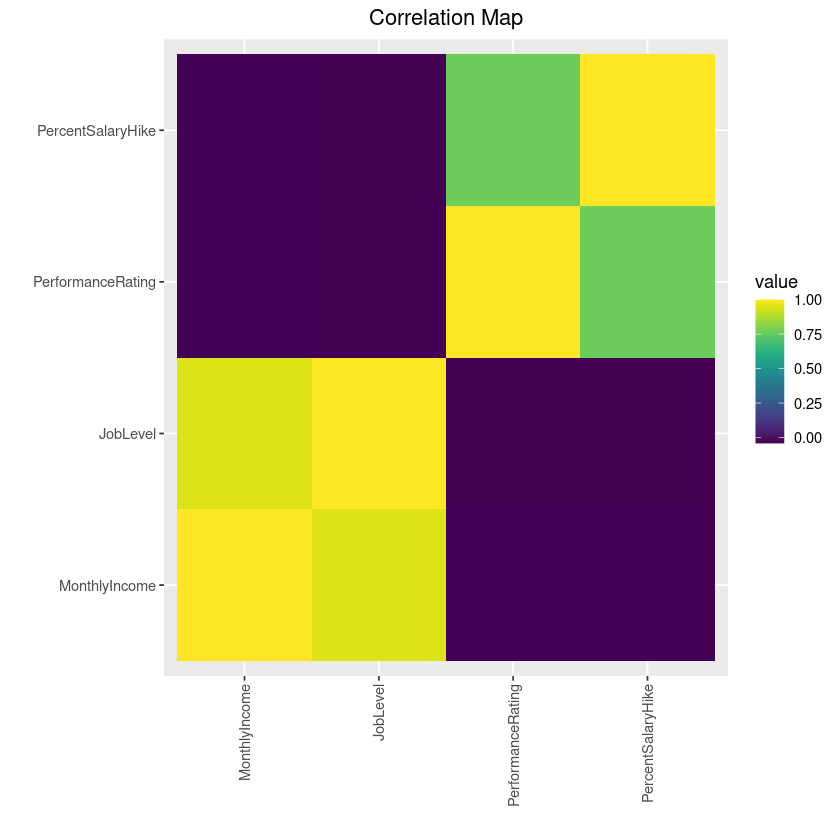

In [11]:
# Correlation
tr1 <- train[cols]
plot_correlation(tr1, limit = 0.7)

## Cox Proportional Hazard: Feature Selection

There is another assumption of proportional hazard for CoxPH, which can be checked by performing statistical test on Schoenfeld residuals. The error message from `check_proportional_hazard()` suggests that `Department` and `JobRole` should be taken out from the test due to large fitted coefficients, although we will still include in the feature selection.

The result below, and a separate look at the residual plots, suggest that `JobLevel`, `MonthlyIncome` violate this assumption. We remove these from our feature when fitting our initial model.

In [12]:
focus_cols <- cols[!(cols %in% c("Department", "JobRole"))]
check_proportional_hazard(coxph_model(train[focus_cols]))

coxph_cols <- cols[!(cols %in% c("JobLevel", "MonthlyIncome"))]

                            chisq df       p
BusinessTravel           3.53e+00  2 0.17137
DailyRate                4.05e-06  1 0.99840
DistanceFromHome         1.29e-01  1 0.71959
Education                8.50e-01  1 0.35656
EducationField           4.10e+00  5 0.53470
EnvironmentSatisfaction  2.87e-01  1 0.59245
Gender                   2.22e-02  1 0.88153
HourlyRate               1.12e-01  1 0.73805
JobInvolvement           4.89e-03  1 0.94427
JobLevel                 1.49e+01  1 0.00012
JobSatisfaction          2.94e-01  1 0.58745
MaritalStatus            2.10e+00  2 0.34981
MonthlyIncome            1.84e+01  1 1.8e-05
MonthlyRate              8.48e-01  1 0.35710
NumCompaniesWorked       1.64e+00  1 0.20036
OverTime                 3.30e-01  1 0.56581
PercentSalaryHike        1.15e+00  1 0.28395
PerformanceRating        8.63e-01  1 0.35282
RelationshipSatisfaction 5.08e-03  1 0.94317
StockOptionLevel         8.64e-02  1 0.76881
TrainingTimesLastYear    7.20e+00  1 0.00731
WorkLifeBa

Now we try our first iteration below. The concordance index of the initial model on training set with all (feasible) columns selected is around $80\%$, with the PEC graph showing that our model has averagely around $90\%$ accuracy ($10\%$ error) in predicting employee attrition within the span of 10 years.

[1] "Univariate Cox score:"
                 JobRole                 OverTime         StockOptionLevel 
               0.7438635                0.6351870                0.6267936 
           MaritalStatus           JobInvolvement  EnvironmentSatisfaction 
               0.6201861                0.5962203                0.5841794 
         JobSatisfaction                Education           BusinessTravel 
               0.5616110                0.5552936                0.5546820 
          EducationField       NumCompaniesWorked                   Gender 
               0.5466502                0.5437304                0.5396587 
RelationshipSatisfaction         DistanceFromHome          WorkLifeBalance 
               0.5384756                0.5375470                0.5371184 
               DailyRate        PercentSalaryHike    TrainingTimesLastYear 
               0.5328056                0.5258454                0.5173850 
       PerformanceRating               HourlyRate           

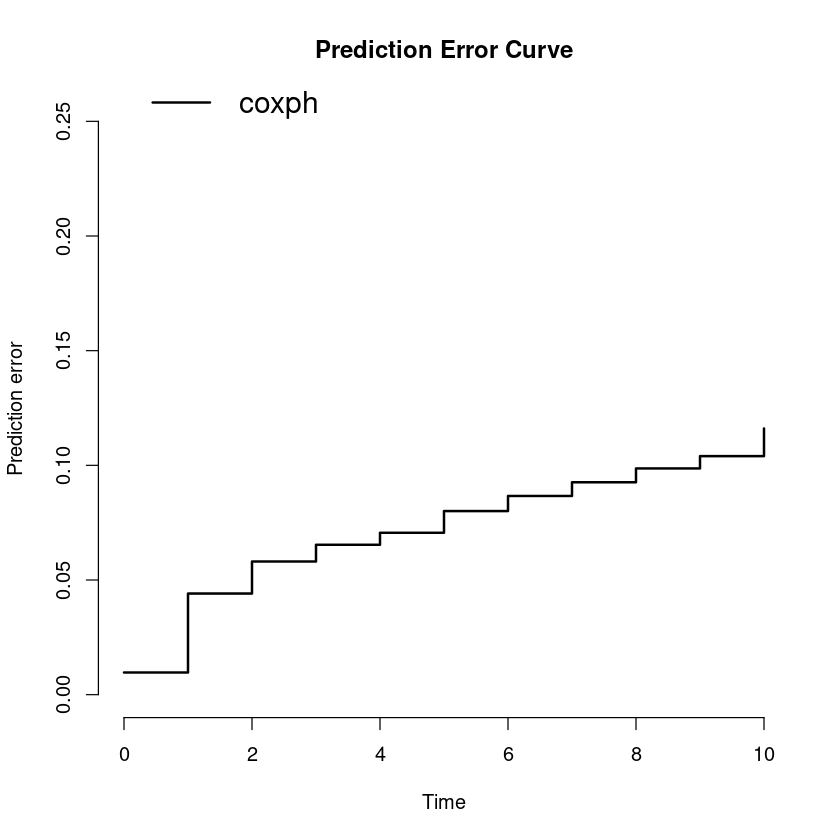

In [13]:
# First iteration
options(warn = -1) # Suppress warnings due to big coxph coefficients

tr1c <- train[coxph_cols]
print_coxph_var_rank(tr1c)

print_c_index(tr1c[coxph_cols], coxph_model)
plot_pec(hr[coxph_cols], coxph_model)

options(warn = 0) # Reactivate warnings

We can see that (under this particular seed) `JobRole` has much higher univariate concordance index compared to others. By taking heuristics that a difference of less than 1% as *not powerful enough*, and considering the benchmark c-index of 0.5 (achieved by a random assigner model), it seems that top-4 covariates (in this case: `JobRole`, `OverTime`, `StockOptionLevel` and `MaritalStatus`) seem like a good idea for feature selection.

**The tuning of the number of features in CoxPH seems to suggest that picking top-4 variables will hit the balance between increased accuracy and simplicity (at around c-index $\approx$ 70\%).**

In [14]:
options(warn = -1) 

for (feature_num in 1:10) {
    cross_val(hr, coxph_model, coxph_score, feature_num) 
}

options(warn = 0)

[1] "Performance score via concordance index, for feature number = 1:"
[1] "Mean: 0.638340776208549"
[1] 0.6288315 0.6288315 0.6288315 0.6288315 0.6763778
[1] "SE: 0.0212633253445773"
[1] "Performance score via concordance index, for feature number = 2:"
[1] "Mean: 0.662339809945803"
[1] 0.6647651 0.6647651 0.6647651 0.6526388 0.6647651
[1] "SE: 0.00542305526989444"
[1] "Performance score via concordance index, for feature number = 3:"
[1] "Mean: 0.683056599082158"
[1] 0.6886260 0.6816642 0.6816642 0.6816642 0.6816642
[1] "SE: 0.00311340906222867"
[1] "Performance score via concordance index, for feature number = 4:"
[1] "Mean: 0.691352175764436"
[1] 0.6858230 0.6996507 0.6858230 0.6996412 0.6858230
[1] "SE: 0.00757116124183735"
[1] "Performance score via concordance index, for feature number = 5:"
[1] "Mean: 0.693903808265555"
[1] 0.6886863 0.6985492 0.6851850 0.6985492 0.6985492
[1] "SE: 0.00648034814589198"
[1] "Performance score via concordance index, for feature number = 6:"
[1] "

We can further examine influential factors in our CoxPH model:

1. If a covariate's score is significantly higher compared to others (and this is a pretty subjective notion), it might worth to see if it appears often across models.


2. If a covariate appear often in the picks, *chances are*, it is an influential factor with similar properties accross the model.


3. An additional advantage if it has a relatively large effect.

## Random Survival Forest: Feature Selection

We develop Random Survival Forest model for our data now. The number of trees used in RSF is on the lower scale (100) for faster process. Note that there is no proportional hazarda assumption here, so the initial feature set can be incorporated here.

The concordance index is extremely high at around $90\%$, with PEC error under $7.5\%$ across ten years.

[1] "Variable importance:"
                JobLevel            MonthlyIncome                 OverTime 
             0.150605526              0.124892689              0.115804063 
 EnvironmentSatisfaction                  JobRole         StockOptionLevel 
             0.049777445              0.043984399              0.043971619 
         WorkLifeBalance       NumCompaniesWorked            MaritalStatus 
             0.033114891              0.030892424              0.029671676 
        DistanceFromHome          NotWorkingYears           JobInvolvement 
             0.025963157              0.025420211              0.025248336 
   YearsAtOtherCompanies RelationshipSatisfaction           EducationField 
             0.021889295              0.018406417              0.016761712 
         JobSatisfaction    TrainingTimesLastYear                DailyRate 
             0.016447049              0.016232868              0.013857477 
       PercentSalaryHike               Department            

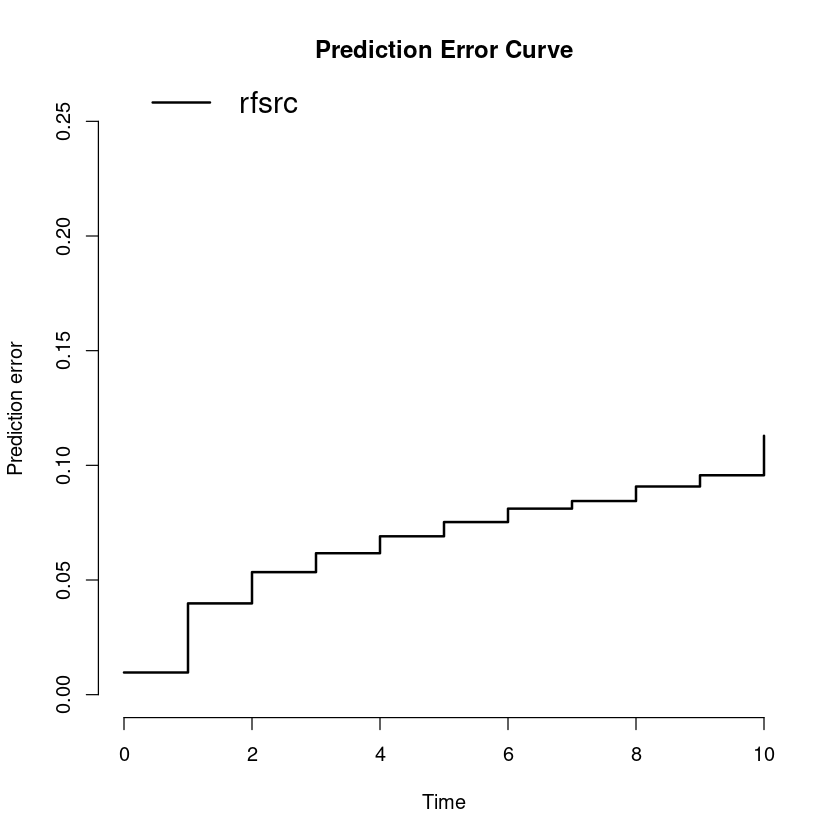

In [15]:
# First iteration
tr1r <- train[cols]
print_rsf_var_rank(tr1r)

print_c_index(hr[cols], rsf_model)
plot_pec(hr[cols], rsf_model)

The prominent group of importance features considered in RSF are `JobLevel`, `OverTime` and `MonthlyIncome`. We note previously that `JobLevel` and `MonthlyIncome` are highly correlated, but the theoretical implication in Random Forest is that one of the collinear variable will be picked as important, while the other's importance is highly reduced. However, in this case, `MonthlyIncome` still perform much better compared to other variables.

**As a result, while they may not have multiplicative relationship to attriton risk, we may hypothesise that both `JobLevel` and `MonthlyIncome` are highly contributing factors for employee attrition.**

Other features such as `EnvironmentSatisfaction` `JobRole`, `StockOptionLevel` also appear influential. The variable `JobRole` is a categorical data with several levels (i.e. 6), which might bias the RSF algorithm in favor of it.

First preview indicates that top-9 variables might be appropriate, and that we should start cross-validating from three features since Author strongly suspects that `JobLevel`, `MonthlyIncome` and `OverTime` are importance.

**Our result below suggests that around 7 to 8 top features in RSF might be a good spot with c-index $\approx$ 85 \%**.

In [16]:
for (feature_num in 3:12) {
    cross_val(hr, rsf_model, rsf_importance, feature_num) 
}

[1] "Performance score via concordance index, for feature number = 3:"
[1] "Mean: 0.748860051296116"
[1] 0.7140233 0.7521065 0.7520012 0.7859611 0.7402082
[1] "SE: 0.0259101908229045"
[1] "Performance score via concordance index, for feature number = 4:"
[1] "Mean: 0.812723315355205"
[1] 0.8125949 0.7734666 0.8172212 0.8430073 0.8173266
[1] "SE: 0.0249982553895226"
[1] "Performance score via concordance index, for feature number = 5:"
[1] "Mean: 0.823734820708747"
[1] 0.8594161 0.8516934 0.7817436 0.7819520 0.8438691
[1] "SE: 0.0386305861574282"
[1] "Performance score via concordance index, for feature number = 6:"
[1] "Mean: 0.837269156438809"
[1] 0.8245325 0.8676737 0.8165721 0.8256068 0.8519607
[1] "SE: 0.0216036795837048"
[1] "Performance score via concordance index, for feature number = 7:"
[1] "Mean: 0.86576603142922"
[1] 0.8636192 0.8557533 0.8441870 0.8853670 0.8799036
[1] "SE: 0.0169896093986472"
[1] "Performance score via concordance index, for feature number = 8:"
[1] "Mean:

## Exploratory Analysis

Most companies would like to know what contributes to employee attrition, but given limited number of employees, it is a hard task from statistical standpoint to balance giving uncertainty. Exploratory Analysis provides both insights that can be actioned pragmatically, while also allow statistical hypotheses to arise and correct errors.

We examine if any attrition patterns develop among features, via plots such as histogram and scatter plots. To prevent plot cluttering, here we present ones from `JobRole` and `MonthlyIncome`:

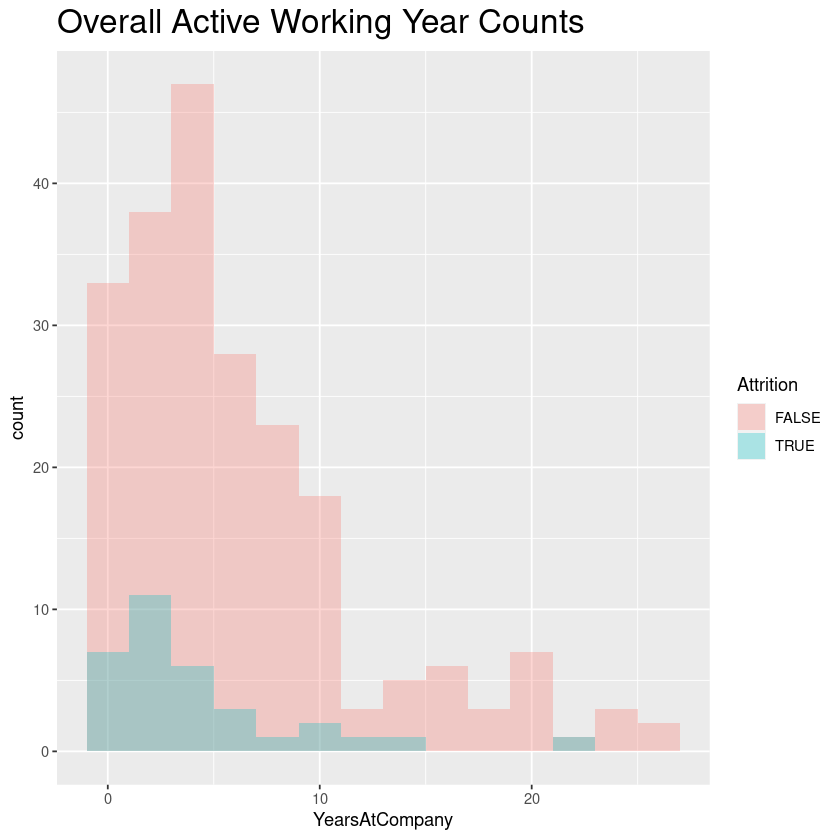

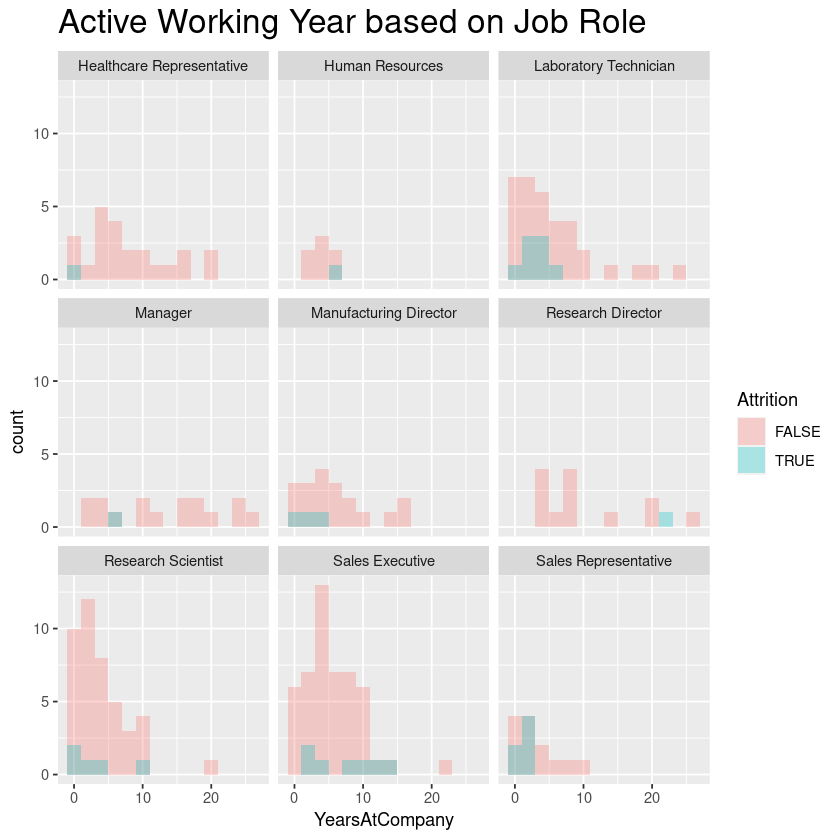

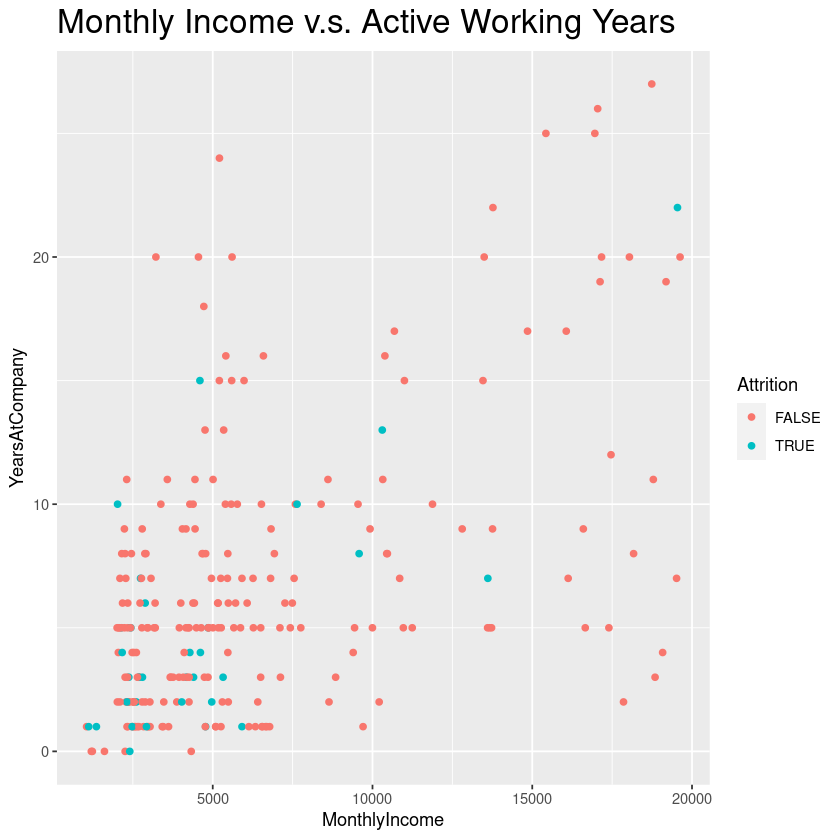

In [17]:
explore = train[sample(nrow(train), 250), ]

# Overall frequency distribution:
ggplot(data = explore) +
  geom_histogram(aes(x = YearsAtCompany, fill = Attrition), alpha = 0.3, binwidth = 2, position = "identity") +
  ggtitle("Overall Active Working Year Counts") +
  theme(plot.title = element_text(size = 20))

ggplot(data = explore) +
  geom_histogram(aes(x = YearsAtCompany, fill = Attrition), alpha = 0.3, binwidth = 2, position = "identity") +
  facet_wrap(JobRole ~ .) +
  ggtitle("Active Working Year based on Job Role") +
  theme(plot.title = element_text(size = 20))

ggplot(data = explore) +
  geom_point(aes(x = MonthlyIncome, y = YearsAtCompany, color = Attrition)) +
  ggtitle("Monthly Income v.s. Active Working Years") +
  theme(plot.title = element_text(size = 20))

From the graph above, the density curve for Sales Representatives is more to the left compared to the overall density curve, and with more prominent attrition density curve. In fact, Sales Representatives roles have a whopping $35\%$ attrition rate (see below cell). This is therefore a key group we can focus on to mitigate employee attrition.

Meanwhile, the vast majority of exiting employees have a monthly income under $11,000. This does not necessarily mean that we should give blanket pay increases to reduce attrition, especially considering its tie to job level. But it is important to reassess any mismatches between expectations and compensation given one's role, and perform career welfare and wellness strategies.

In [18]:
# For reference, this shows high historical attrition rate for Sales Reps
suppressMessages(library(dplyr))

aggregated_attrition <- function (df, col) {
  options(warn = -1) # Suppress warnings
    
  # Best for categorical (unless numerical int range is small)
  result <- df[, c("Attrition", col)] %>%
  group_by_(col) %>%
  summarize(
    AttritionCount = sum(Attrition),
    TotalEmployees = n(),
    AttritionRate = AttritionCount/TotalEmployees
  )
    
  options(warn = 0) # Reactivate warnings
  return(result)
}

aggregated_attrition(explore, "JobRole")

JobRole,AttritionCount,TotalEmployees,AttritionRate
<fct>,<int>,<int>,<dbl>
Healthcare Representative,1,24,0.04166667
Human Resources,1,8,0.12500000
Laboratory Technician,8,42,0.19047619
Manager,1,17,0.05882353
Manufacturing Director,3,22,0.13636364
Research Director,1,14,0.07142857
Research Scientist,5,48,0.10416667
Sales Executive,7,56,0.12500000
Sales Representative,6,19,0.31578947


## Completing Final Models

Our final model is formed by two methods of CoxPH and RSF, each with optimal features of four and seven respectively.

In [19]:
coxph_feature_num <- 4
rsf_feature_num <- 7
coxph_cols <- c("Attrition", "YearsAtCompany", "JobRole", "OverTime", "StockOptionLevel", "MaritalStatus")
rsf_cols <- c("Attrition", "YearsAtCompany", "JobLevel", "OverTime", "MonthlyIncome", "StockOptionLevel", "JobRole",
              "EnvironmentSatisfaction", "WorkLifeBalance")
coxph_final_model <- coxph_model(hr[coxph_cols])
rsf_final_model <- rsf_model(hr[rsf_cols])

---

## Predicting Employee Attrition Risk

We produce the estimated cumulative hazard function (CHF) of attrition for each of our employee $i$ for Random Survival Forest model, and hazard ratio relative to the exponent of mean for Cox Proportional Hazard model.

In particular, the rank for employee risk based on $RSF$ is determined by the long-term CHF for the next five years, since it is commonly the period where companies may conduct review of their structural performance.

In [20]:
# Appending predictions
years = 5
rsf_risk <- predict(rsf_final_model, hr)$chf[, 1 + (0:years)] # matrix
rsf_survival_probs <- predict(rsf_final_model, hr)$survival[, 1 + (0:years)]
hr["Hazard_RSF_in_5_Years"] <- rsf_risk[, 5]
hr["HazardRatio_CoxPH"] <- predict(coxph_final_model, hr, type = "risk")

preview_cols <- c("EmployeeNumber", coxph_cols, rsf_cols, "Hazard_RSF_in_5_Years", "HazardRatio_CoxPH")

# Table sorted by hazards
cutoff = 20
sorted <- function (df, key_col) {
  df <- df[df["Attrition"] == FALSE, ]
  return(row.names(df)[order(df[, key_col], decreasing = TRUE)][1:cutoff])
}
hr_sorted_rsf <- hr[sorted(hr, "Hazard_RSF_in_5_Years"), ]
hr_sorted_coxph <- hr[sorted(hr, "HazardRatio_CoxPH"), ]
head(hr_sorted_rsf[, preview_cols])
head(hr_sorted_coxph[, preview_cols])

,EmployeeNumber,Attrition,YearsAtCompany,JobRole,OverTime,StockOptionLevel,MaritalStatus,Attrition.1,YearsAtCompany.1,JobLevel,OverTime.1,MonthlyIncome,StockOptionLevel.1,JobRole.1,EnvironmentSatisfaction,WorkLifeBalance,Hazard_RSF_in_5_Years,HazardRatio_CoxPH
,<int>,<lgl>,<int>,<fct>,<lgl>,<int>,<fct>,<lgl>,<int>,<int>,<lgl>,<int>,<int>,<fct>,<int>,<int>,<dbl>,<dbl>
1291,2021,FALSE,2,Sales Representative,TRUE,0,Single,FALSE,2,1,TRUE,2380,0,Sales Representative,3,3,0.9230353,97.19928
840,1286,FALSE,4,Laboratory Technician,TRUE,0,Single,FALSE,4,1,TRUE,2154,0,Laboratory Technician,4,2,0.7694213,47.53515
1188,1850,FALSE,5,Laboratory Technician,TRUE,0,Single,FALSE,5,1,TRUE,2379,0,Laboratory Technician,4,2,0.7667084,47.53515
999,1556,FALSE,3,Sales Representative,TRUE,0,Single,FALSE,3,1,TRUE,2644,0,Sales Representative,3,2,0.6843765,97.19928
749,1131,FALSE,2,Research Scientist,TRUE,0,Single,FALSE,2,1,TRUE,2070,0,Research Scientist,4,4,0.6534305,24.92786
1259,1974,FALSE,1,Laboratory Technician,TRUE,3,Divorced,FALSE,1,1,TRUE,1129,3,Laboratory Technician,4,3,0.6401027,14.15923


,EmployeeNumber,Attrition,YearsAtCompany,JobRole,OverTime,StockOptionLevel,MaritalStatus,Attrition.1,YearsAtCompany.1,JobLevel,OverTime.1,MonthlyIncome,StockOptionLevel.1,JobRole.1,EnvironmentSatisfaction,WorkLifeBalance,Hazard_RSF_in_5_Years,HazardRatio_CoxPH
,<int>,<lgl>,<int>,<fct>,<lgl>,<int>,<fct>,<lgl>,<int>,<int>,<lgl>,<int>,<int>,<fct>,<int>,<int>,<dbl>,<dbl>
999,1556,FALSE,3,Sales Representative,TRUE,0,Single,FALSE,3,1,TRUE,2644,0,Sales Representative,3,2,0.68437652,97.19928
1291,2021,FALSE,2,Sales Representative,TRUE,0,Single,FALSE,2,1,TRUE,2380,0,Sales Representative,3,3,0.92303529,97.19928
634,957,FALSE,18,Laboratory Technician,TRUE,0,Single,FALSE,18,1,TRUE,4721,0,Laboratory Technician,4,3,0.32430412,47.53515
840,1286,FALSE,4,Laboratory Technician,TRUE,0,Single,FALSE,4,1,TRUE,2154,0,Laboratory Technician,4,2,0.76942129,47.53515
1015,1586,FALSE,10,Laboratory Technician,TRUE,0,Single,FALSE,10,1,TRUE,4723,0,Laboratory Technician,2,3,0.31765085,47.53515
1033,1611,FALSE,10,Laboratory Technician,TRUE,0,Single,FALSE,10,2,TRUE,5769,0,Laboratory Technician,3,3,0.05546129,47.53515


## Visualisation with `plotly`

We also use `plotly` to derive an interactive visualisation of the list of top $20$ employees at risk, where user can group employees according to several factors described in  trends of attrition risks based on various factors.

By examining the overlapping of top employees based on RSF and CoxPH, it seems that Employee $2021$ and $1556$ are particularly prone to quitting.

In [121]:
# Plotly implementation
suppressMessages(library(plotly))

fig <- plot_ly()

# --- Adding traces
# RSF
employee_row_num_wrt_ <- match(1:length(hr_sorted_rsf), hr_sorted_rsf)
for (rank in 1:cutoff) {
  employee_row_num <- as.numeric(rownames(hr_sorted_rsf)[rank])
  employee_row <- hr_sorted_rsf[rank, ]
  x <- 0:(ncol(rsf_risk)-1)
  y <- rsf_risk[employee_row_num, ]
  fig <- fig %>% add_trace(x = x,
                           y = y,
                           name = employee_row["EmployeeNumber"],
                           type = "scatter", mode = "lines+markers", # Every time you put type, it assign DOMNum = 0
                           marker = list(size = 6),
                           line = list(shape = "spline", width = 2),
                           hovertemplate = paste0("<b>", rank, ". Employee ", employee_row["EmployeeNumber"], "</b>",
                                                 "<br>Year: %{x}",
                                                 "<br>Cumulative risk: %{y:.2f}"),
                           hoverlabel = list(font_size = 16),
                           legendrank = rank,
                           legendgroup = employee_row["EmployeeNumber"],
                           showlegend = TRUE)
}

# CoxPH
fig <- fig %>% add_trace(data = hr_sorted_coxph,
                         x = 1:cutoff,
                         y = ~HazardRatio_CoxPH,
                         type = "bar",
                         marker = list(color = 1:cutoff, colorscale = list(c(0, "#64a1f4"), c(1, "#bfe6b5"))), # blue-green
                         hovertemplate = paste0("<b>%{x}. Employee ", hr_sorted_coxph$EmployeeNumber, "</b>",
                                                "<br>Risk ratio: %{y:.2f}"),
                         hoverlabel = list(bgcolor = "white", font_size = 16),
                         showlegend = FALSE,
                         visible = FALSE)


# --- Decorators
# Including the baseline
avg_cum_hazard <- -log(1-mean(hr[, "Attrition"]))
baseline <- list(
  type = "line", x0 = 0, x1 = 5, y0 = avg_cum_hazard, y1 = avg_cum_hazard,
  line = list(dash = "dash", width = 4, color = "#82A0D8")
)
fig <- fig %>% add_text(
  x = 0.3, y = 0.22,
  text = "Average hazard", textfont = list(family = "sans serif", size = 12),
  showlegend = FALSE
)

# Helper functions to group CHF based on variables
library(RColorBrewer)
unique_index <- function(x) {
  unique_vals <- unique(x)
  first_occur <- integer(length(unique_vals))
  for (i in 1:length(unique_vals)) {
    first_occur[i] <- which(x == unique_vals[i])[1]
  }
  return(first_occur)
}
create_buttons <- function(vars) {
  lapply(vars, function(var) {
    color_num <- 8
    color_palletes <- brewer.pal(color_num, "Set2")
    var_factors <- as.numeric(factor(hr_sorted_rsf[[var]]))
    button <- list(
      method = "restyle",
      label = var,
      args = list(list( # Please read Plotly.js for detailed documentation (not R/Python)
        line.color = color_palletes[var_factors %% color_num + 1],
        marker.color = color_palletes[var_factors %% color_num + 1],
        legendrank = if(var == "EmployeeNumber") 1:cutoff else var_factors,
        legendgroup = hr_sorted_rsf[[var]],
        showlegend = 1:cutoff %in% unique_index(var_factors),
        name = as.character(hr_sorted_rsf[[var]])
      ), 1:cutoff - 1)
    )
    return(button)
  })
}


# --- Setting layout
rsf_layout = list( 
  title = "Top 20 High-Risk Employees, according to RSF's Cumulative Risk in Five Years",
  shapes = list(baseline),
  xaxis = list(title = "Year", range = c(0, 5), zerolinecolor = 'white'),
  yaxis = list(title = "Accummulated Risk over Time", range = c(0, 1.5), zerolinecolor = 'white'),
  `annotations[1].visible` = TRUE,
  `updatemenus[1].visible` = TRUE
)
coxph_layout = list(
  title = "Top 20 High-Risk Employees, according to Risk Ratio",
  shapes = list(),
  xaxis = list(title = "Rank", tickmode = "array", tickvals = 1:cutoff, zerolinecolor = 'white'),
  yaxis = list(title = "Risk Ratio", zerolinecolor = 'white'),
  `annotations[1].visible` = FALSE,
  `updatemenus[1].visible` = FALSE
)
fig <- fig %>% layout( # do.call soon
  title = "Top 20 High-Risk Employees, according to RSF's Cumulative Risk in Five Years",
  shapes = list(baseline),
  xaxis = list(title = "Year", range = c(0, 5), zerolinecolor = 'white'),
  yaxis = list(title = "Accummulated Risk over Time", range = c(0, 1.5), zerolinecolor = 'white'),
  margin = list(l = 50, t = 50, b = 50, r = 50),
  plot_bgcolor = '#e5ecf6',
  annotations = list(
    list(
      xanchor = "left", yanchor = "top", x = -0.5, y = 1, xref = "paper", yref = "paper", 
      text = "Method", align = "left", showarrow = FALSE
    ), list(
      xanchor = "left", yanchor = "top", x = -0.5, y = 0.8, xref = "paper", yref = "paper", 
      text = "Based on", align = "left", showarrow = FALSE
    )
  ),
  updatemenus = list(
    list(
      xanchor = "left", yanchor = "top", x = -0.5, y = 0.95, xref = "paper", yref = "paper",
      showactive = TRUE,
      buttons = list(
        list(
          label = "Random Survival Forest",
          method = "update",
          args = list(list(visible = c(rep(TRUE, cutoff), FALSE, TRUE)), rsf_layout, 1:(cutoff+2) - 1)
        ),
        list(
          label = "Cox Proportional Hazard",
          method = "update",
          args = list(list(visible = c(rep(FALSE, cutoff), TRUE, FALSE)), coxph_layout, 1:(cutoff+2) - 1)
        )
      )
    ), list(
      xanchor = "left", yanchor = "top", x = -0.5, y = 0.75, xref = "paper", yref = "paper",
      showactive = TRUE,
      buttons = create_buttons(c("EmployeeNumber", "EnvironmentSatisfaction", "JobLevel", "JobRole",
                                 "MonthlyIncome", "MaritalStatus", "OverTime", "StockOptionLevel", "WorkLifeBalance"))
    )
  )
)

# Build the HTML widget, only for the case of nbviewer
# Otherwise, simply the line `fig` will suffice
htmlwidgets::saveWidget(as_widget(fig), "plot.html")
IRdisplay::display_html("<iframe seamless src='plot.html' width=1000, height=600></iframe>")
# fig

---

## Recommended Strategies

### Overtime Management

Excessive overtime can lead to burnout among employees. Implement strategies to manage and reduce overtime, such as workload distribution, hiring additional staff, or arranging flexible work arrangements.

### Targetted Retention Programs

Develop specific retention programs focused on high-risk job roles, such as Sales Representatives and Laboratory Technicians, to address their unique needs and challenges. Provide additional support, training, and incentives to enhance job satisfaction and reduce attrition rates among employees in these roles.

###  Career Welfare Support

Survey employees to understand motivations, pain points, and workplace satisfaction beyond just compensation. Enhanced recognition, wellness programs, and emphasis on work-life integration.

### Financial Benefits & Compensation

Ensure that compensation and benefits packages are competitive and aligned with industry standards. Consider revising the stock option plans or other incentives to increase employee motivation and loyalty.

---

## Epilogue: Accuracy Check on Data

In [23]:
prepare <- function(df) {
  df[cat_cols] <- lapply(df[cat_cols], factor)
  df[bool_cols] <- lapply(df[bool_cols], function (col) { ifelse(col %in% c("Yes", "Y"), TRUE, FALSE) })
  df <- df[!(names(df) %in% c("EmployeeNumber", single_value_cols))]
  df["NotWorkingYears"] <- df["Age"] - df["TotalWorkingYears"]
  df["YearsAtOtherCompanies"] <- df["TotalWorkingYears"] - df["YearsAtCompany"]
  return(df)
}

VERI_with_features <- prepare(VERI)
print(c_index(VERI_with_features[coxph_cols], coxph_final_model))
print(c_index(VERI_with_features[rsf_cols], rsf_final_model))

   coxph 
0.852528 
    rfsrc 
0.8096381 
